# Greek Parliament Proceedings

The paper is based on a dataset containing Greek Parliament proceedings, which you can find at https://zenodo.org/record/2587904, along with its explanations. For better understanding of the dataset, you can also read https://lab.imedd.org/en/parliamentary-minutes-from-1989-until-today/.

---

> Assigned by Panos Louridas, Associate Professor <br />
> Written by Aliki Ntouzgou, Undergraduate Student <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> aliki.ntouzgou@gmail.com

# Obtaining the Data

* The assignment has been done in a Colab Notebook, but you can also run it in a Jupyter Notebook. 
  * In order to read the csv file in the Colab Notebook, I created a file in my Google Drive named "data", saved the csv file there and then read it as a csv. If you want to work on a Colab Notebook too, I suggest you do the same.
  * If you want to work on a Jupyter Notebook, you can download the csv file and save it anywhere you want in your disk and read it from there, as a csv file. 

## Installations and Imports

We import and install all the necessary libraries that we will use throughout the assignment.

In [65]:
pip install squarify

In [66]:
pip install bar_chart_race

In [68]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from plotnine import *
import squarify 
import bar_chart_race as bcr
import plotly.express as px
from math import pi
from bokeh.io import output_file, show, output_notebook
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum

%matplotlib inline

In [69]:
import nltk
import string, re
from collections import Counter
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer
from scipy.stats import sem
from imblearn.over_sampling import SMOTE 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

In [70]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional
from keras.layers.core import Dense, SpatialDropout1D
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping

## Reading the Data

As mentioned above, we are going to read the csv file from the Google Drive.

In [71]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [72]:
proceedings = pd.read_csv("/content/gdrive/My Drive/data/Greek_Parliament_Proceedings_1989_2019.csv")
print(proceedings.shape)
proceedings.head()

(1194407, 8)


,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech
0,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...
1,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...
2,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ..."
3,NaN,1989-07-03,period 5,session 1,sitting 1,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα."
4,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...


# EDA (Exploratory Data Analysis)

Before we try to classify or alter our data in any way, it is good practice that we explore them. And with that, I mean extract some useful metrics about them, in order to understand the structure and the context of our dataset.


## Distribution of Sessions Through the Years

We will start off with some simple metrics. <br> <br>First of all, we are going to examine the distribution of parliamentary sessions through the years. In order to do so, we will first create a column that contains the year corresponding to each row :

In [73]:
proceedings['sitting_year'] = pd.DatetimeIndex(proceedings['sitting_date']).year
print(proceedings.shape)
proceedings.head()

(1194407, 9)


,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech,sitting_year
0,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...,1989
1,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...,1989
2,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ...",1989
3,NaN,1989-07-03,period 5,session 1,sitting 1,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα.",1989
4,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...,1989


Now, we need to create a dataframe that describes for each year its total unique sittings and sessions. We will use the `groupby()` method to do so:

In [9]:
unique_sessions_per_year = proceedings.groupby(['sitting_year', 'parliamentary_session']).count().reset_index()
unique_sessions_per_year = unique_sessions_per_year[['sitting_year', 'parliamentary_session']]
print(unique_sessions_per_year.shape)
unique_sessions_per_year.head()

(91, 2)


,sitting_year,parliamentary_session
0,1989,session 1
1,1990,session 1
2,1990,session 1 continuation of plenary session
3,1990,summer '90
4,1991,continuation of summer recess '91


Text(0.5, 1.0, '\n Distribution of Sessions Through the Years \n')

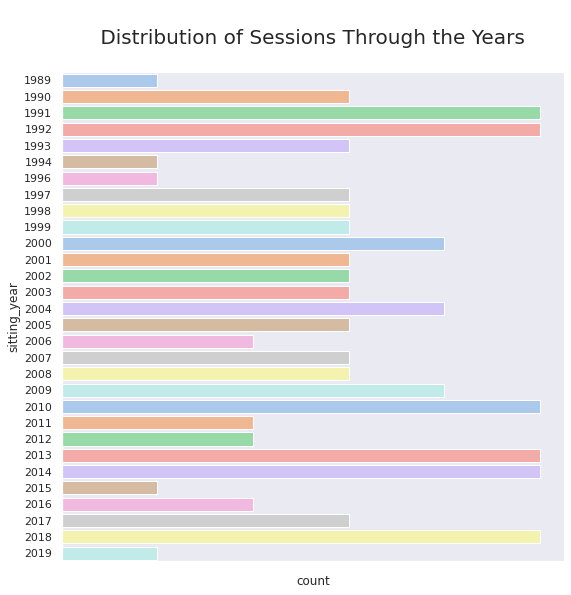

In [10]:
sns.set_theme(style="dark")
fig = plt.gcf()
fig.set_size_inches(9, 9)
ax = sns.countplot(y="sitting_year", data=unique_sessions_per_year, palette="pastel")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.title("\n Distribution of Sessions Through the Years \n", size=20)

## Distribution of Sittings by Political Party Through the Years

We are going to work in the same way as above, to examine the distribution of parliamentary sittings per political party throughout the years:

In [11]:
unique_parties_per_year = proceedings.groupby(['sitting_year', 'political_party', 'parliamentary_sitting']).count().reset_index()
count = 1
unique_parties_per_year['count'] = 1
unique_parties_per_year = unique_parties_per_year.groupby(['sitting_year', 'political_party']).sum(['count']).reset_index()
unique_parties_per_year = unique_parties_per_year[['sitting_year', 'political_party', 'count']]
print(unique_parties_per_year.shape)
unique_parties_per_year.head()

(263, 3)


,sitting_year,political_party,count
0,1989,βουλη,39
1,1989,κομμουνιστικο κομμα ελλαδας,17
2,1989,κομμουνιστικο κομμα ελλαδας εσωτερικου,15
3,1989,λαικος ορθοδοξος συναγερμος,4
4,1989,νεα δημοκρατια,38


In [12]:
unique_parties_per_year_pivot = unique_parties_per_year.pivot(index='sitting_year', columns='political_party', values='count')
unique_parties_per_year_pivot.head()

political_party,ανεξαρτητοι (εκτος κομματος),ανεξαρτητοι δημοκρατικοι βουλευτες,ανεξαρτητοι ελληνες - πανος καμμενος,ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια,αντιπολιτευση,βουλη,δημοκρατικη ανανεωση,δημοκρατικη αριστερα,δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα),δημοκρατικο κοινωνικο κινημα,ενωση κεντρωων,κομμουνιστικο κομμα ελλαδας,κομμουνιστικο κομμα ελλαδας εσωτερικου,λαικη ενοτητα,λαικος ορθοδοξος συναγερμος,λαικος συνδεσος - χρυση αυγη,νεα δημοκρατια,οικολογοι εναλλακτικοι (ομοσπονδια οικολογικων εναλλακτικων οργανωσεων),πανελληνιο σοσιαλιστικο κινημα,πολιτικη ανοιξη,συνασπισμος ριζοσπαστικης αριστερας,συνασπισμος της αριστερας των κινηματων και της οικολογιας,το ποταμι
sitting_year,,,,,,,,,,,,,,,,,,,,,,,
1989,NaN,NaN,NaN,NaN,NaN,39.0,NaN,NaN,NaN,NaN,NaN,17.0,15.0,NaN,4.0,NaN,38.0,2.0,39.0,NaN,NaN,35.0,NaN
1990,65.0,NaN,NaN,NaN,2.0,95.0,5.0,NaN,NaN,NaN,NaN,26.0,NaN,NaN,5.0,NaN,97.0,27.0,97.0,NaN,NaN,97.0,NaN
1991,61.0,NaN,NaN,NaN,3.0,124.0,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN,7.0,NaN,124.0,40.0,124.0,NaN,NaN,122.0,NaN
1992,113.0,NaN,NaN,NaN,1.0,140.0,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,9.0,NaN,142.0,33.0,136.0,NaN,NaN,141.0,NaN
1993,61.0,NaN,NaN,NaN,NaN,116.0,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN,4.0,NaN,116.0,13.0,115.0,29.0,NaN,114.0,NaN


In [13]:
unique_parties_per_year_pivot = unique_parties_per_year_pivot.fillna(0)

In [14]:
bcr.bar_chart_race(df = unique_parties_per_year_pivot, title = "Distribution of Sittings by Political Party Through the Years", n_bars=23, orientation='h', fixed_order= False, 
                   cmap = 'accent', period_length=1500, figsize=(6, 4))

## Parliamentary Sessions per Parliamentary Period

And so on...

In [15]:
sessions_per_period = proceedings.groupby(['parliamentary_period', 'parliamentary_session']).count().reset_index()
sessions_per_period = sessions_per_period[['parliamentary_period', 'parliamentary_session']]
print(sessions_per_period.shape)
sessions_per_period.head()

(66, 2)


,parliamentary_period,parliamentary_session
0,period 10 presided parliamentary republic,session 1
1,period 10 presided parliamentary republic,session 1 continuation of plenary session
2,period 10 presided parliamentary republic,session 2
3,period 10 presided parliamentary republic,session 3
4,period 10 presided parliamentary republic,session 4


Text(0.5, 1.0, '\n Parliamentary Sessions per Parliamentary Period \n')

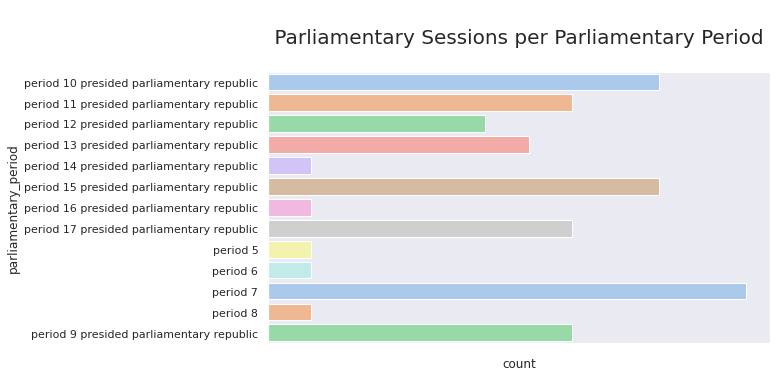

In [16]:
sns.set_theme(style="dark")
fig = plt.gcf()
fig.set_size_inches(9, 5)
ax = sns.countplot(y="parliamentary_period", data=sessions_per_period, palette="pastel")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.title("\n Parliamentary Sessions per Parliamentary Period \n", size=20)

## Parliamentary Sittings per Parliamentary Sessions

In [17]:
sessions = proceedings.groupby(['parliamentary_session']).count().reset_index()
sessions = sessions[['parliamentary_session', 'parliamentary_sitting']]
print(sessions.shape)
sessions.head()

(37, 2)


,parliamentary_session,parliamentary_sitting
0,'09 summer recess section 1,4098
1,'09 summer recess section 2,3925
2,'10 summer recess section 1,2535
3,'10 summer recess section 2,2309
4,'10 summer recess section 3,2679


Text(0.5, 1.0, '\n Parliamentary Sittings per Parliamentary Sessions \n')

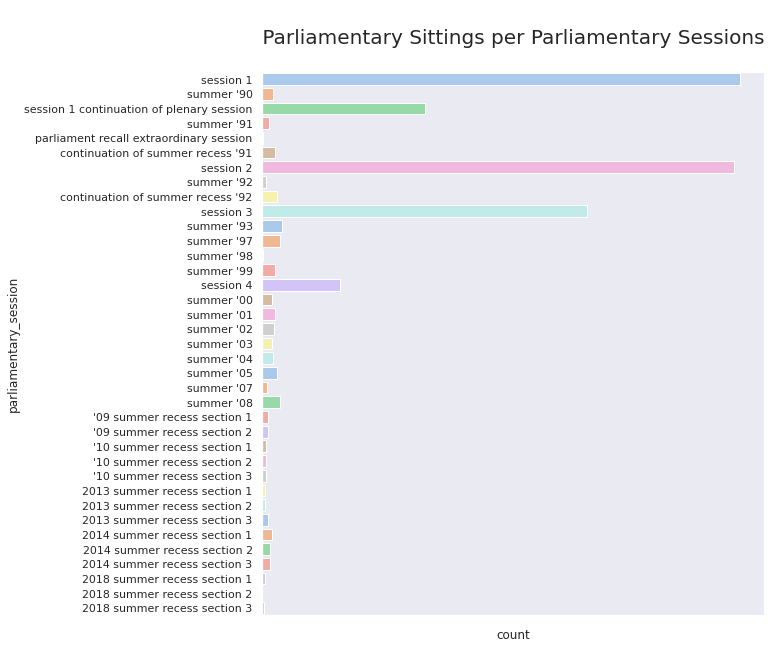

In [18]:
sns.set_theme(style="dark")
fig = plt.gcf()
fig.set_size_inches(9, 10)
ax = sns.countplot(y="parliamentary_session", data=proceedings, palette="pastel")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.title("\n Parliamentary Sittings per Parliamentary Sessions \n", size=20)

## Political Parties per Parliamentary Period


In [19]:
party_per_period = proceedings.groupby(['political_party', 'parliamentary_period']).count().reset_index()
party_per_period = party_per_period[['parliamentary_period', 'political_party']]
count = 1
party_per_period['count'] = count
print(party_per_period.shape)
party_per_period.head()

(119, 3)


,parliamentary_period,political_party,count
0,period 10 presided parliamentary republic,ανεξαρτητοι (εκτος κομματος),1
1,period 11 presided parliamentary republic,ανεξαρτητοι (εκτος κομματος),1
2,period 12 presided parliamentary republic,ανεξαρτητοι (εκτος κομματος),1
3,period 13 presided parliamentary republic,ανεξαρτητοι (εκτος κομματος),1
4,period 15 presided parliamentary republic,ανεξαρτητοι (εκτος κομματος),1


In [20]:
party_per_period_grouped = party_per_period.groupby(['parliamentary_period']).sum(['count']).reset_index()
print(party_per_period_grouped.shape)
party_per_period_grouped.head()

(13, 2)


,parliamentary_period,count
0,period 10 presided parliamentary republic,8
1,period 11 presided parliamentary republic,8
2,period 12 presided parliamentary republic,11
3,period 13 presided parliamentary republic,10
4,period 14 presided parliamentary republic,3


In [21]:
output_file("pie.html")

x = {
    'period 10 presided parliamentary rep': 8,
    'period 11 presided parliamentary rep': 8,
    'period 12 presided parliamentary rep': 11,
    'period 13 presided parliamentary rep': 10,
    'period 14 presided parliamentary rep': 3,
    'period 15 presided parliamentary rep': 12,
    'period 16 presided parliamentary rep': 12,
    'period 17 presided parliamentary rep': 12,
    'period 5': 7,
    'period 6': 9,
    'period 7': 11,
    'period 8': 7,
    'period 9': 9
}

data = pd.Series(x).reset_index(name='value').rename(columns={'index':'country'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = Category20c[len(x)]

output_notebook()

p = figure(plot_height=400, title="Hovering Pie Chart for Political Parties per Parliamentary Period", toolbar_location=None,
           tools="hover", tooltips="@country: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.3,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='country', source=data)

p.legend.title = 'Parliamentary Periods'
p.legend.title_text_font_style = 'bold'
p.title.text_font_size = "19px"
p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

## Distribution of Speeches per Member

In [22]:
proceedings.member_name.value_counts()

κακλαμανης χρηστου αποστολος                                                                                                      35338
σγουριδης σγουρη παναγιωτης                                                                                                       31656
σουρλας ιωαννη γεωργιος                                                                                                           28394
κρητικος νικολαου παναγιωτης                                                                                                      24529
γειτονας ιωαννη κωνσταντινος                                                                                                      18673
                                                                                                                                  ...  
τραγακης παναγιωτη ιωαννης / μαρκογιαννακης εμμανουηλ χρηστος                                                                         1
φραγκος αναστασιου δημητριος / κρητικος νικολαου

Since we have many different member names and plotting their distribution would not give us any useful information, we are going to try plotting the distribution of speeches per member for the last 10 years, of the political parties with the most sittings:

In [23]:
top_2 = proceedings.loc[proceedings['political_party'].isin(['νεα δημοκρατια', 'πανελληνιο σοσιαλιστικο κινημα'])].copy()
top_2_10 = top_2.loc[top_2['sitting_year'] >= 2010 ].copy()
print(top_2_10.shape)
top_2_10.head()

(168568, 9)


,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech,sitting_year
732387,νιωτης δημητριου γρηγοριος,2010-01-11,period 13 presided parliamentary republic,session 1,sitting 40,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κυρίες και κύριοι συνάδελφοι, αφού πρώτα ευχη...",2010
732390,νιωτης δημητριου γρηγοριος,2010-01-11,period 13 presided parliamentary republic,session 1,sitting 40,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Η Βουλή ενέκρινε τη ζητηθείσα άδεια. Επίσης, ...",2010
732392,νιωτης δημητριου γρηγοριος,2010-01-11,period 13 presided parliamentary republic,session 1,sitting 40,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Η Βουλή ενέκρινε τη ζητηθείσα άδεια. Πριν εισ...,2010
732393,νιωτης δημητριου γρηγοριος,2010-01-11,period 13 presided parliamentary republic,session 1,sitting 40,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κυρίες και κύριοι συνάδελφοι, εισερχόμαστε στ...",2010
732394,τσιαρας αλεξανδρου κωνσταντινος,2010-01-11,period 13 presided parliamentary republic,session 1,sitting 40,νεα δημοκρατια,NaN,"Σας ευχαριστώ πολύ, κύριε Πρόεδρε. Κυρίες και...",2010


In [24]:
speech_per_member = top_2_10.member_name.value_counts()
speech_per_member = speech_per_member.to_frame().reset_index()
speech_per_member.columns = ['member_name', 'count']
speech_per_member = speech_per_member.sort_values(by=['count'], ascending=False)
print(speech_per_member.shape)
speech_per_member.head()

(345, 2)


,member_name,count
0,κακλαμανης μιχαηλ νικητας,9967
1,μαρκογιαννακης εμμανουηλ χρηστος,9583
2,νιωτης δημητριου γρηγοριος,8138
3,αργυρης ιωαννη ευαγγελος,7231
4,πολυδωρας γεωργιου βυρων,6495


Since we still have too many data, it is best that we visualize the top 15 speakers of the parties:

In [25]:
speech_per_member_15 = speech_per_member.head(15)
speech_per_member_15.head()

,member_name,count
0,κακλαμανης μιχαηλ νικητας,9967
1,μαρκογιαννακης εμμανουηλ χρηστος,9583
2,νιωτης δημητριου γρηγοριος,8138
3,αργυρης ιωαννη ευαγγελος,7231
4,πολυδωρας γεωργιου βυρων,6495


In [26]:
speech_per_member_15_final = pd.merge(speech_per_member_15, top_2[['member_name', 'political_party']], on='member_name', how='left')
speech_per_member_15_final = speech_per_member_15_final.drop_duplicates()
speech_per_member_15_final.head()

,member_name,count,political_party
0,κακλαμανης μιχαηλ νικητας,9967,νεα δημοκρατια
12640,μαρκογιαννακης εμμανουηλ χρηστος,9583,νεα δημοκρατια
23579,νιωτης δημητριου γρηγοριος,8138,πανελληνιο σοσιαλιστικο κινημα
33664,αργυρης ιωαννη ευαγγελος,7231,πανελληνιο σοσιαλιστικο κινημα
42829,πολυδωρας γεωργιου βυρων,6495,νεα δημοκρατια


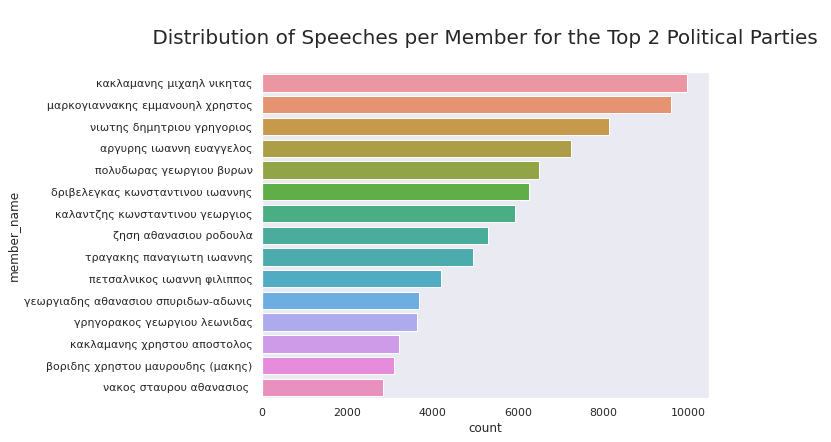

In [27]:
plt.figure(figsize=(8, 6))
plt.title('\n Distribution of Speeches per Member for the Top 2 Political Parties \n', fontsize=20)
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="count", y="member_name", data=speech_per_member_15_final)

## Distribution of Members per Political Party 

In [28]:
members_by_party = proceedings.groupby(['political_party', 'member_name']).count().reset_index()
print(members_by_party.shape)
members_by_party.head()

(1513, 9)


,political_party,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,speaker_info,speech,sitting_year
0,ανεξαρτητοι (εκτος κομματος),αγατσα αριστειδη αριαδνη,2,2,2,2,0,2,2
1,ανεξαρτητοι (εκτος κομματος),αηδονης ευαγγελου χρηστος,34,34,34,34,0,34,34
2,ανεξαρτητοι (εκτος κομματος),αθανασιαδης θεοδωρου αλεξανδρος,34,34,34,34,0,34,34
3,ανεξαρτητοι (εκτος κομματος),αλεξοπουλος δημητριου χρυσοβαλαντης,18,18,18,18,0,18,18
4,ανεξαρτητοι (εκτος κομματος),αμοιριδης παναγιωτη ιωαννης,240,240,240,240,0,240,240


In [29]:
count = 1
members_by_party['count'] = count
members_by_party.head()

,political_party,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,speaker_info,speech,sitting_year,count
0,ανεξαρτητοι (εκτος κομματος),αγατσα αριστειδη αριαδνη,2,2,2,2,0,2,2,1
1,ανεξαρτητοι (εκτος κομματος),αηδονης ευαγγελου χρηστος,34,34,34,34,0,34,34,1
2,ανεξαρτητοι (εκτος κομματος),αθανασιαδης θεοδωρου αλεξανδρος,34,34,34,34,0,34,34,1
3,ανεξαρτητοι (εκτος κομματος),αλεξοπουλος δημητριου χρυσοβαλαντης,18,18,18,18,0,18,18,1
4,ανεξαρτητοι (εκτος κομματος),αμοιριδης παναγιωτη ιωαννης,240,240,240,240,0,240,240,1


In [30]:
members_by_party = members_by_party.groupby(['political_party']).sum('count').reset_index()
print(members_by_party.shape)
members_by_party.head()

(21, 9)


,political_party,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,speaker_info,speech,sitting_year,count
0,ανεξαρτητοι (εκτος κομματος),29951,29951,29951,29951,8246,29951,29951,122
1,ανεξαρτητοι δημοκρατικοι βουλευτες,1769,1769,1769,1769,275,1769,1769,14
2,ανεξαρτητοι ελληνες - πανος καμμενος,13785,13785,13785,13785,8855,13785,13785,22
3,ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατ...,5521,5521,5521,5521,2317,5521,5521,15
4,δημοκρατικη ανανεωση,6,6,6,6,0,6,6,1


*Try hovering through the plot.*

In [31]:
fig = px.scatter(members_by_party, x="count", y="political_party", color="political_party", hover_data=['political_party'], width=1200, height=450)
fig.update_layout(yaxis={'visible': False, 'showticklabels': False}, title={'text': "Distribution of Members per Political Party",'y':0.95,'x':0.23, 'xanchor': 'center', 'yanchor': 'top'})
fig.show()

## Distribution of Members for the Top 4 Political Parties

In [32]:
top4 = members_by_party.loc[members_by_party['political_party'].isin(['νεα δημοκρατια', 'πανελληνιο σοσιαλιστικο κινημα', 'συνασπισμος ριζοσπαστικης αριστερας', 
                                                                      'κομμουνιστικο κομμα ελλαδας'])].copy()
top4

,political_party,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,speaker_info,speech,sitting_year,count
9,κομμουνιστικο κομμα ελλαδας,78631,78631,78631,78631,20452,78631,78631,58
14,νεα δημοκρατια,385149,385149,385149,385149,232316,385143,385149,448
16,πανελληνιο σοσιαλιστικο κινημα,377399,377399,377399,377399,221139,377395,377399,435
18,συνασπισμος ριζοσπαστικης αριστερας,126571,126571,126571,126571,68836,126571,126571,212


<b>Να πω πως θα μπορουσε να πει κανεις πως το παρακατω treemap συνοψιζει και ολη την πολιτικη ιστορια της χωρας μας /  τα κυριαρχα κομματα των τελευταιων δεκαετιων.</b>

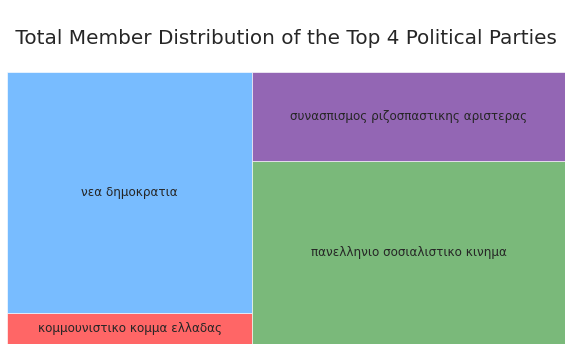

In [33]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(10, 5)
squarify.plot(sizes=top4['count'], label=top4['political_party'], color=["red","dodgerblue","forestgreen", "indigo"], alpha=.6)
plt.axis('off')
plt.title("\n Total Member Distribution of the Top 4 Political Parties \n", fontsize=20)
plt.show()

##  Distribution of Parliamentary Sittings Per Political Party Through the Years 

In [34]:
sittings_years = proceedings.groupby(['political_party', 'sitting_year']).count().reset_index()
print(sittings_years.shape)
sittings_years.head()

(263, 9)


,political_party,sitting_year,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,speaker_info,speech
0,ανεξαρτητοι (εκτος κομματος),1990,499,499,499,499,499,5,499
1,ανεξαρτητοι (εκτος κομματος),1991,527,527,527,527,527,0,527
2,ανεξαρτητοι (εκτος κομματος),1992,1740,1740,1740,1740,1740,0,1740
3,ανεξαρτητοι (εκτος κομματος),1993,564,564,564,564,564,0,564
4,ανεξαρτητοι (εκτος κομματος),2000,2,2,2,2,2,0,2


/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



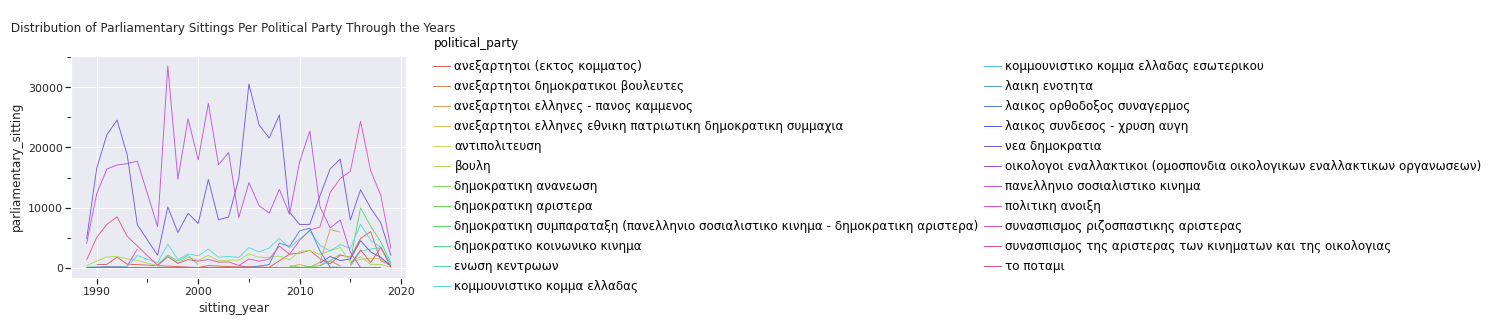

<ggplot: (-9223363284135222833)>

In [35]:
p = (ggplot(data = sittings_years) + \
    geom_line(mapping = aes(x='sitting_year', y='parliamentary_sitting', color='political_party'), 
               na_rm=True) + \
    ggtitle("\n Distribution of Parliamentary Sittings Per Political Party Through the Years \n"))
p + theme_seaborn()

# Classification without Neural Networks

We should: 
* Train at least two non-neural network algorithms to learn to classify a speech. The target variable should be the political party of the speaker.

* If a party does not have enough support (in the Machine Learning sense, i.e., too few speeches), we may excise it from the dataset if you detect that you cannot get results for it.

* Split the data to training and testing datasets, try the different algorithms with cross validation on the training dataset, and find the best hyperparameters for the best algorithm. Note that parameters for bag of words and tf-idf construction can be very important.

* Report the scores; once we find the best algorithm and the best hyperparameters, report the score on the test data.

* To gauge the efficacy of the algorithm, report also the results of a baseline classifier, using, for instance, scikit-learn's [`DummyClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html).

## Data Preprocessing
First, we will define the dataset that we will use for classification.

In [74]:
data = proceedings[['political_party', 'speech', 'sitting_year']]
print(data.shape)
data.head()

(1194407, 3)


,political_party,speech,sitting_year
0,πανελληνιο σοσιαλιστικο κινημα,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...,1989
1,πανελληνιο σοσιαλιστικο κινημα,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...,1989
2,πανελληνιο σοσιαλιστικο κινημα,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ...",1989
3,βουλη,"Μάλιστα, μάλιστα.",1989
4,πανελληνιο σοσιαλιστικο κινημα,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...,1989


In [75]:
data = data.loc[data['sitting_year'] >= 2015]
data

,political_party,speech,sitting_year
986317,νεα δημοκρατια,"Κυρίες και κύριοι Βουλευτές, συγκαλείται η Βο...",2015
986318,νεα δημοκρατια,"Επίσης, έχω την τιμή να ανακοινώσω στο Σώμα τ...",2015
986319,νεα δημοκρατια,Σας ενημερώνω ότι μετά τον Αγιασμό θα ακολουθ...,2015
986320,νεα δημοκρατια,Παρακαλώ τις κυρίες και τους κυρίους Βουλευτέ...,2015
986321,νεα δημοκρατια,Σε αυτό το σημείο καταθέτω στα Πρακτικά τη σύ...,2015
...,...,...,...
1194402,κομμουνιστικο κομμα ελλαδας,"Κύριε Πρόεδρε, οι καταστροφές προφανώς δεν ήτ...",2019
1194403,νεα δημοκρατια,"Ορίστε, κύριε Υπουργέ, έχετε τον λόγο.",2019
1194404,νεα δημοκρατια,"Αρκεί και το κεντρικό κράτος, κύριε Υπουργέ, ...",2019
1194405,βουλη,"Μάλιστα, μάλιστα.",2019


In [76]:
data['sitting_year'].unique()

array([2015, 2016, 2017, 2018, 2019])

In [77]:
data = data[['political_party', 'speech']]
print(data.shape)
data.head()

(208090, 2)


,political_party,speech
986317,νεα δημοκρατια,"Κυρίες και κύριοι Βουλευτές, συγκαλείται η Βο..."
986318,νεα δημοκρατια,"Επίσης, έχω την τιμή να ανακοινώσω στο Σώμα τ..."
986319,νεα δημοκρατια,Σας ενημερώνω ότι μετά τον Αγιασμό θα ακολουθ...
986320,νεα δημοκρατια,Παρακαλώ τις κυρίες και τους κυρίους Βουλευτέ...
986321,νεα δημοκρατια,Σε αυτό το σημείο καταθέτω στα Πρακτικά τη σύ...


Then, we are going to remove all tha NaN values.

In [78]:
data.isna().sum()

political_party    4
speech             0
dtype: int64

In [79]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)
data.head()

(208086, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,political_party,speech
0,νεα δημοκρατια,"Κυρίες και κύριοι Βουλευτές, συγκαλείται η Βο..."
1,νεα δημοκρατια,"Επίσης, έχω την τιμή να ανακοινώσω στο Σώμα τ..."
2,νεα δημοκρατια,Σας ενημερώνω ότι μετά τον Αγιασμό θα ακολουθ...
3,νεα δημοκρατια,Παρακαλώ τις κυρίες και τους κυρίους Βουλευτέ...
4,νεα δημοκρατια,Σε αυτό το σημείο καταθέτω στα Πρακτικά τη σύ...


Now, let us see how many speeches we have for each political party.

In [80]:
data = data.drop_duplicates()
print(data.shape)
data

(147087, 2)


,political_party,speech
0,νεα δημοκρατια,"Κυρίες και κύριοι Βουλευτές, συγκαλείται η Βο..."
1,νεα δημοκρατια,"Επίσης, έχω την τιμή να ανακοινώσω στο Σώμα τ..."
2,νεα δημοκρατια,Σας ενημερώνω ότι μετά τον Αγιασμό θα ακολουθ...
3,νεα δημοκρατια,Παρακαλώ τις κυρίες και τους κυρίους Βουλευτέ...
4,νεα δημοκρατια,Σε αυτό το σημείο καταθέτω στα Πρακτικά τη σύ...
...,...,...
208079,νεα δημοκρατια,"Πριν φύγετε, να τα καταθέσετε στα Πρακτικά γι..."
208080,νεα δημοκρατια,Τα υπόλοιπα στη δευτερολογία σας.Κύριε Συντυχ...
208081,κομμουνιστικο κομμα ελλαδας,"Κύριε Πρόεδρε, οι καταστροφές προφανώς δεν ήτ..."
208083,νεα δημοκρατια,"Αρκεί και το κεντρικό κράτος, κύριε Υπουργέ, ..."


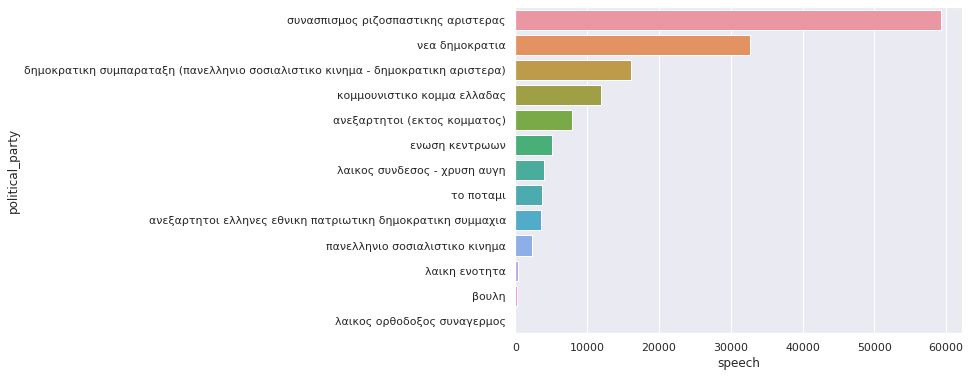

In [81]:
data_count = data.groupby(['political_party']).count().reset_index()
data_count = data_count.sort_values(by='speech', ascending=False)
plt.figure(figsize=(8, 6))
sns.set_theme(style="darkgrid")
ax = sns.barplot(x="speech", y="political_party", data=data_count)

In [82]:
data = data[data['political_party'] != 'ανεξαρτητοι (εκτος κομματος)']
data = data[data['political_party'] != 'ενωση κεντρωων']
data = data[data['political_party'] != 'λαικος συνδεσος - χρυση αυγη']
data = data[data['political_party'] != 'το ποταμι']
data = data[data['political_party'] != 'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια']
data = data[data['political_party'] != 'πανελληνιο σοσιαλιστικο κινημα']
data = data[data['political_party'] != 'λαικη ενοτητα']
data = data[data['political_party'] != 'βουλη']
data = data[data['political_party'] != 'λαικος ορθοδοξος συναγερμος']
data

,political_party,speech
0,νεα δημοκρατια,"Κυρίες και κύριοι Βουλευτές, συγκαλείται η Βο..."
1,νεα δημοκρατια,"Επίσης, έχω την τιμή να ανακοινώσω στο Σώμα τ..."
2,νεα δημοκρατια,Σας ενημερώνω ότι μετά τον Αγιασμό θα ακολουθ...
3,νεα δημοκρατια,Παρακαλώ τις κυρίες και τους κυρίους Βουλευτέ...
4,νεα δημοκρατια,Σε αυτό το σημείο καταθέτω στα Πρακτικά τη σύ...
...,...,...
208079,νεα δημοκρατια,"Πριν φύγετε, να τα καταθέσετε στα Πρακτικά γι..."
208080,νεα δημοκρατια,Τα υπόλοιπα στη δευτερολογία σας.Κύριε Συντυχ...
208081,κομμουνιστικο κομμα ελλαδας,"Κύριε Πρόεδρε, οι καταστροφές προφανώς δεν ήτ..."
208083,νεα δημοκρατια,"Αρκεί και το κεντρικό κράτος, κύριε Υπουργέ, ..."


Now, we will convert any uppercase letter in lowercase:

In [83]:
data["speech"] = data["speech"].str.lower()
data

,political_party,speech
0,νεα δημοκρατια,"κυρίες και κύριοι βουλευτές, συγκαλείται η βο..."
1,νεα δημοκρατια,"επίσης, έχω την τιμή να ανακοινώσω στο σώμα τ..."
2,νεα δημοκρατια,σας ενημερώνω ότι μετά τον αγιασμό θα ακολουθ...
3,νεα δημοκρατια,παρακαλώ τις κυρίες και τους κυρίους βουλευτέ...
4,νεα δημοκρατια,σε αυτό το σημείο καταθέτω στα πρακτικά τη σύ...
...,...,...
208079,νεα δημοκρατια,"πριν φύγετε, να τα καταθέσετε στα πρακτικά γι..."
208080,νεα δημοκρατια,τα υπόλοιπα στη δευτερολογία σας.κύριε συντυχ...
208081,κομμουνιστικο κομμα ελλαδας,"κύριε πρόεδρε, οι καταστροφές προφανώς δεν ήτ..."
208083,νεα δημοκρατια,"αρκεί και το κεντρικό κράτος, κύριε υπουργέ, ..."


We will remove all the numbers:

In [84]:
data['speech'] = data['speech'].str.replace('\d+', '')
data

,political_party,speech
0,νεα δημοκρατια,"κυρίες και κύριοι βουλευτές, συγκαλείται η βο..."
1,νεα δημοκρατια,"επίσης, έχω την τιμή να ανακοινώσω στο σώμα τ..."
2,νεα δημοκρατια,σας ενημερώνω ότι μετά τον αγιασμό θα ακολουθ...
3,νεα δημοκρατια,παρακαλώ τις κυρίες και τους κυρίους βουλευτέ...
4,νεα δημοκρατια,σε αυτό το σημείο καταθέτω στα πρακτικά τη σύ...
...,...,...
208079,νεα δημοκρατια,"πριν φύγετε, να τα καταθέσετε στα πρακτικά γι..."
208080,νεα δημοκρατια,τα υπόλοιπα στη δευτερολογία σας.κύριε συντυχ...
208081,κομμουνιστικο κομμα ελλαδας,"κύριε πρόεδρε, οι καταστροφές προφανώς δεν ήτ..."
208083,νεα δημοκρατια,"αρκεί και το κεντρικό κράτος, κύριε υπουργέ, ..."


Then, we are going to remove all the exclamation marks:

In [85]:
data['speech'] = data['speech'].str.replace('[^\w\s]','')
data

,political_party,speech
0,νεα δημοκρατια,κυρίες και κύριοι βουλευτές συγκαλείται η βου...
1,νεα δημοκρατια,επίσης έχω την τιμή να ανακοινώσω στο σώμα τι...
2,νεα δημοκρατια,σας ενημερώνω ότι μετά τον αγιασμό θα ακολουθ...
3,νεα δημοκρατια,παρακαλώ τις κυρίες και τους κυρίους βουλευτέ...
4,νεα δημοκρατια,σε αυτό το σημείο καταθέτω στα πρακτικά τη σύ...
...,...,...
208079,νεα δημοκρατια,πριν φύγετε να τα καταθέσετε στα πρακτικά για...
208080,νεα δημοκρατια,τα υπόλοιπα στη δευτερολογία σαςκύριε συντυχά...
208081,κομμουνιστικο κομμα ελλαδας,κύριε πρόεδρε οι καταστροφές προφανώς δεν ήτα...
208083,νεα δημοκρατια,αρκεί και το κεντρικό κράτος κύριε υπουργέ να...


Next, we are going to load and remove all the greek stopwords, according to the NLTK library:

In [86]:
nltk.download('stopwords')
", ".join(stopwords.words('greek'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"αλλα, αν, αντι, απο, αυτα, αυτεσ, αυτη, αυτο, αυτοι, αυτοσ, αυτουσ, αυτων, αἱ, αἳ, αἵ, αὐτόσ, αὐτὸς, αὖ, γάρ, γα, γα^, γε, για, γοῦν, γὰρ, δ', δέ, δή, δαί, δαίσ, δαὶ, δαὶς, δε, δεν, δι', διά, διὰ, δὲ, δὴ, δ’, εαν, ειμαι, ειμαστε, ειναι, εισαι, ειστε, εκεινα, εκεινεσ, εκεινη, εκεινο, εκεινοι, εκεινοσ, εκεινουσ, εκεινων, ενω, επ, επι, εἰ, εἰμί, εἰμὶ, εἰς, εἰσ, εἴ, εἴμι, εἴτε, η, θα, ισωσ, κ, καί, καίτοι, καθ, και, κατ, κατά, κατα, κατὰ, καὶ, κι, κἀν, κἂν, μέν, μή, μήτε, μα, με, μεθ, μετ, μετά, μετα, μετὰ, μη, μην, μἐν, μὲν, μὴ, μὴν, να, ο, οι, ομωσ, οπωσ, οσο, οτι, οἱ, οἳ, οἷς, οὐ, οὐδ, οὐδέ, οὐδείσ, οὐδεὶς, οὐδὲ, οὐδὲν, οὐκ, οὐχ, οὐχὶ, οὓς, οὔτε, οὕτω, οὕτως, οὕτωσ, οὖν, οὗ, οὗτος, οὗτοσ, παρ, παρά, παρα, παρὰ, περί, περὶ, ποια, ποιεσ, ποιο, ποιοι, ποιοσ, ποιουσ, ποιων, ποτε, που, ποῦ, προ, προσ, πρόσ, πρὸ, πρὸς, πως, πωσ, σε, στη, στην, στο, στον, σόσ, σύ, σύν, σὸς, σὺ, σὺν, τά, τήν, τί, τίς, τίσ, τα, ταῖς, τε, την, τησ, τι, τινα, τις, τισ, το, τοί, τοι, τοιοῦτος, τοιοῦτοσ, τον, τοτε,

In [87]:
STOPWORDS = set(stopwords.words('greek'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data["speech"] = data["speech"].apply(lambda text: remove_stopwords(text))
data

,political_party,speech
0,νεα δημοκρατια,κυρίες κύριοι βουλευτές συγκαλείται βουλή κηρύ...
1,νεα δημοκρατια,επίσης έχω τιμή ανακοινώσω σώμα επιστολές πρωθ...
2,νεα δημοκρατια,σας ενημερώνω ότι αγιασμό ακολουθήσει οριζόμεν...
3,νεα δημοκρατια,παρακαλώ κυρίες τους κυρίους βουλευτές επιθυμο...
4,νεα δημοκρατια,αυτό σημείο καταθέτω στα πρακτικά τη σύμφωνη ο...
...,...,...
208079,νεα δημοκρατια,πριν φύγετε καταθέσετε στα πρακτικά μπορέσει π...
208080,νεα δημοκρατια,υπόλοιπα δευτερολογία σαςκύριε συντυχάκη έχετε...
208081,κομμουνιστικο κομμα ελλαδας,κύριε πρόεδρε καταστροφές προφανώς ήταν κάτι α...
208083,νεα δημοκρατια,αρκεί κεντρικό κράτος κύριε υπουργέ δίνει χρήμ...


Next, we are going to remove the 10 most common words, after we first removed the stopwords:

In [88]:
cnt = Counter()
for text in data["speech"].values:
    for word in text.split():
        cnt[word] += 1 
cnt.most_common(10)

[('της', 260824),
 ('είναι', 217583),
 ('από', 180021),
 ('ότι', 168187),
 ('τη', 131716),
 ('αυτό', 102144),
 ('τους', 99147),
 ('σας', 90971),
 ('έχει', 77357),
 ('μας', 69443)]

In [89]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
data["speech"] = data["speech"].apply(lambda text: remove_freqwords(text))
data

,political_party,speech
0,νεα δημοκρατια,κυρίες κύριοι βουλευτές συγκαλείται βουλή κηρύ...
1,νεα δημοκρατια,επίσης έχω τιμή ανακοινώσω σώμα επιστολές πρωθ...
2,νεα δημοκρατια,ενημερώνω αγιασμό ακολουθήσει οριζόμενος σύντα...
3,νεα δημοκρατια,παρακαλώ κυρίες κυρίους βουλευτές επιθυμούν υψ...
4,νεα δημοκρατια,σημείο καταθέτω στα πρακτικά σύμφωνη ομόφωνη γ...
...,...,...
208079,νεα δημοκρατια,πριν φύγετε καταθέσετε στα πρακτικά μπορέσει π...
208080,νεα δημοκρατια,υπόλοιπα δευτερολογία σαςκύριε συντυχάκη έχετε...
208081,κομμουνιστικο κομμα ελλαδας,κύριε πρόεδρε καταστροφές προφανώς ήταν κάτι α...
208083,νεα δημοκρατια,αρκεί κεντρικό κράτος κύριε υπουργέ δίνει χρήμ...


Finally, we are going to lemmatize our text:

In [90]:
data['speech'] = data['speech'].astype(str)

In [91]:
nltk.download('wordnet')
def get_lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

data['speech'] = get_lemmatized_text(data['speech'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Split into train and test data:

In [92]:
hv = HashingVectorizer(strip_accents='unicode', n_features=1000, norm='l1', alternate_sign=False)
hash_vector = hv.fit_transform(data.speech)
X = hash_vector.toarray()
print(hash_vector.shape)

(119920, 1000)


In [93]:
tfidftransformer = TfidfTransformer(smooth_idf=True,use_idf=True)
tf = tfidftransformer.fit_transform(hash_vector)
X = tfidftransformer.fit_transform(X).toarray()

In [94]:
X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.0449318, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [95]:
y = data['political_party']

In [96]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(95936, 1000) (95936,)
(23984, 1000) (23984,)


## SMOTE

As you can see, the train and test dataset is quite disparate. So, we will apply the SMOTE technique, which stands for "Synthetic Minority Over-sampling Technique". The SMOTE technique is one of the most commonly used oversampling methods to solve the imbalanced data problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them. SMOTE synthesises new minority instances between existing minority instances.

In [97]:
sm = SMOTE(random_state = 2) 
x_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_x: {}'.format(x_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



After OverSampling, the shape of train_x: (189692, 1000)
After OverSampling, the shape of train_y: (189692,) 



## Random Forest Classifier 

We will start with a Random Forest Classifier: 

In [ ]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = classifier.predict(x_test)

In [ ]:
print(accuracy_score(y_test, y_pred))

0.5433205470313542


In [ ]:
print(classification_report(y_test,y_pred))

                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.50      0.11      0.18      3197
                                                    κομμουνιστικο κομμα ελλαδας       0.54      0.10      0.17      2412
                                                                 νεα δημοκρατια       0.48      0.34      0.40      6568
                                            συνασπισμος ριζοσπαστικης αριστερας       0.56      0.87      0.68     11807

                                                                       accuracy                           0.54     23984
                                                                      macro avg       0.52      0.35      0.36     23984
                                                                   weighted avg       0.53      0.54      0.48     23984



### Cross Validation:

In [ ]:
rfc_scores = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')
rfc_scores

array([0.52543362, 0.53222982, 0.53865077, 0.53698299, 0.53877585])

## Multinomial Naive Bayes

In [ ]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)
np.mean(y_pred == y_test)

0.4985823882588392

In [ ]:
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.88      0.00      0.00      3197
                                                    κομμουνιστικο κομμα ελλαδας       0.00      0.00      0.00      2412
                                                                 νεα δημοκρατια       0.57      0.03      0.06      6568
                                            συνασπισμος ριζοσπαστικης αριστερας       0.50      0.99      0.66     11807

                                                                       accuracy                           0.50     23984
                                                                      macro avg       0.49      0.26      0.18     23984
                                                                   weighted avg       0.52      0.50      0.34     23984



### Cross Validation:

In [ ]:
mnb_scores = cross_val_score(mnb, X, y, cv=5, scoring='accuracy')
mnb_scores

array([0.49741494, 0.49908272, 0.49954136, 0.50129253, 0.50362742])

## Stochastic Gradient Descent



In [ ]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42)
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)
np.mean(y_pred == y_test)

0.49962474983322214

In [ ]:
print(classification_report(y_test,y_pred))

                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.41      0.02      0.04      3197
                                                    κομμουνιστικο κομμα ελλαδας       0.38      0.01      0.02      2412
                                                                 νεα δημοκρατια       0.45      0.05      0.09      6568
                                            συνασπισμος ριζοσπαστικης αριστερας       0.50      0.98      0.66     11807

                                                                       accuracy                           0.50     23984
                                                                      macro avg       0.44      0.27      0.20     23984
                                                                   weighted avg       0.46      0.50      0.36     23984



### Cross Validation:

In [ ]:
sgd_scores = cross_val_score(sgd, X, y, cv=5, scoring='accuracy')
sgd_scores

array([0.50166778, 0.50208472, 0.50708806, 0.50050033, 0.5007505 ])

## XGBoost Classifier

In [ ]:
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
y_pred = xgbc.predict(x_test)
np.mean(y_pred == y_test)

0.5378168779186124

In [ ]:
print(classification_report(y_test,y_pred))

                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.71      0.07      0.14      3197
                                                    κομμουνιστικο κομμα ελλαδας       0.90      0.07      0.14      2412
                                                                 νεα δημοκρατια       0.52      0.17      0.26      6568
                                            συνασπισμος ριζοσπαστικης αριστερας       0.53      0.96      0.69     11807

                                                                       accuracy                           0.54     23984
                                                                      macro avg       0.67      0.32      0.30     23984
                                                                   weighted avg       0.59      0.54      0.44     23984



### Cross Validation:

In [ ]:
xgbc_scores = cross_val_score(xgbc, X, y, cv=5, scoring='accuracy')
xgbc_scores

array([0.52451634, 0.54131921, 0.54081888, 0.5406521 , 0.54448799])

## LightGBM for Classification

In [ ]:
lgbmc = LGBMClassifier()
lgbmc.fit(x_train, y_train)
y_pred = lgbmc.predict(x_test)
np.mean(y_pred == y_test)

0.5698382254836558

In [ ]:
print(classification_report(y_test,y_pred))

                                                                                 precision    recall  f1-score   support

δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)       0.70      0.13      0.22      3197
                                                    κομμουνιστικο κομμα ελλαδας       0.83      0.18      0.30      2412
                                                                 νεα δημοκρατια       0.54      0.29      0.38      6568
                                            συνασπισμος ριζοσπαστικης αριστερας       0.56      0.92      0.70     11807

                                                                       accuracy                           0.57     23984
                                                                      macro avg       0.66      0.38      0.40     23984
                                                                   weighted avg       0.60      0.57      0.51     23984



### Cross Validation:

In [ ]:
lgbmc_scores = cross_val_score(lgbmc, X, y, cv=5, scoring='accuracy')
lgbmc_scores

array([0.54357071, 0.56408439, 0.56883756, 0.56679453, 0.57242328])

It seems that the LightGBM algorithm for Classification is the optimal for our dataset.<br>
So, we are going to run a Grid Search for this algorithm. Suppose that your computer has the capacity to do so, I would advise you to run a Grid Search for the parameters below:

In [ ]:
'''
parameters = {
              'max_depth': [15, 20, 25, 30, 35],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6],
              'lambda_l2': [0, 10, 15, 35, 40],
              'cat_smooth': [1, 10, 15, 20, 35],
              'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_freq': [2, 4, 5, 6, 8]
}
grid_search = GridSearchCV(lgbmc, param_grid=parameters, scoring='accuracy', cv=3)
grid_search = grid_search.fit(x_train, y_train)
grid_search.best_params_
'''

Due to memory capacity, I could not run the Grid Search above. So, I ran the Grid Search below:

In [ ]:
parameters = {
              'max_depth': [15, 20, 25, 30, 35],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'lambda_l2': [0, 10, 15, 35, 40],
}
grid_search = GridSearchCV(lgbmc, param_grid=parameters, scoring='accuracy', cv=3)
grid_search = grid_search.fit(x_train, y_train)
grid_search.best_params_

{'lambda_l2': 0, 'learning_rate': 0.15, 'max_depth': 30}

In [ ]:
lgbmc = LGBMClassifier(max_depth=30, learning_rate=0.15, lambda_l2=0)
lgbmc.fit(x_train, y_train)
y_pred = lgbmc.predict(x_test)
np.mean(y_pred == y_test)

0.5762591727818546

## Dummy Classifier

In [ ]:
dummy = DummyClassifier()
dummy.fit(x_train, y_train)
DummyClassifier(constant=None, random_state=None, strategy='uniform')
y_pred = dummy.predict(x_test)
np.mean(y_pred == y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning:

The default value of strategy will change from stratified to prior in 0.24.



0.34769012675116745

In [ ]:
dummy = DummyClassifier()
dummy.fit(x_train, y_train)
DummyClassifier(constant=None, random_state=None, strategy='stratified')
y_pred = dummy.predict(x_test)
np.mean(y_pred == y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning:

The default value of strategy will change from stratified to prior in 0.24.



0.35065043362241494

# Classification with a Neural Network

* We will carry out a classification, but this time using a neural network.
* I decided to use a LSTM Recurrent Neural Network.
* I also decided to "wrap" a Bidirectional layer around the LSTM layer in order to increase the classification efficiency.

### LSTM Classifier

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['speech'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 245256 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(data['speech'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (119920, 250)


In [ ]:
Y = pd.get_dummies(data['political_party']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (119920, 4)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(107928, 250) (107928, 4)
(11992, 250) (11992, 4)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1], mask_zero=True))
model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 4)                 804       
Total params: 5,161,604
Trainable params: 5,161,604
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

We will run the neural network for 3 epochs. This seems to be the optimal number of epochs because for every number greater than 3 that I ran the classification, every time the val_loss value started increasing after 3 epochs, symbolizing that the model is probably overfitting.

In [ ]:
epochs = 3
batch_size = 32

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
3036/3036 [==============================] - 2211s 726ms/step - loss: 1.1170 - accuracy: 0.5283 - val_loss: 1.0079 - val_accuracy: 0.5818
Epoch 2/3
3036/3036 [==============================] - 2193s 722ms/step - loss: 0.8529 - accuracy: 0.6514 - val_loss: 1.0603 - val_accuracy: 0.5346
Epoch 3/3
3036/3036 [==============================] - 2194s 723ms/step - loss: 0.7256 - accuracy: 0.7050 - val_loss: 0.9473 - val_accuracy: 0.6195


# Classification Overview



In general, in prediction problems involving unstructured data (i.e. text) artificial neural networks tend to outperform all other algorithms or frameworks. This justifies the fact that we got the best accuracy score from the neural networks classification. However, we can see that in the classification without neural networks, the LightGBM, which is a decision tree based algorithm won the case.

# Text Generation (Bonus)

We should write a text generator that produces speeches like those in the proceedings.
* In order to do so, we will read the data dataframe again, since we are going to apply different preprocessing methods than we did before and we will train a different model.
* The steps followed below are from the text generation tutorial kindly provided by the Tensorflow Hub and you can find it here: https://www.tensorflow.org/tutorials/text/text_generation .


In [ ]:
proceedings = pd.read_csv("/content/gdrive/My Drive/data/Greek_Parliament_Proceedings_1989_2019.csv")
proceedings['sitting_year'] = pd.DatetimeIndex(proceedings['sitting_date']).year
print(proceedings.shape)
proceedings.head()

(1194407, 9)


,member_name,sitting_date,parliamentary_period,parliamentary_session,parliamentary_sitting,political_party,speaker_info,speech,sitting_year
0,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να σ...,1989
1,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Παρακαλείται ο κύριος Γραμματέας να συνοδεύσε...,1989
2,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,"Κύριοι συνάδελφοι, παρακαλώ τη Βουλή να εξουσ...",1989
3,NaN,1989-07-03,period 5,session 1,sitting 1,βουλη,βουλευτης/ες,"Μάλιστα, μάλιστα.",1989
4,κρητικος νικολαου παναγιωτης,1989-07-03,period 5,session 1,sitting 1,πανελληνιο σοσιαλιστικο κινημα,προεδρευων,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...,1989


In [ ]:
proceedings = proceedings[['political_party', 'speech']]

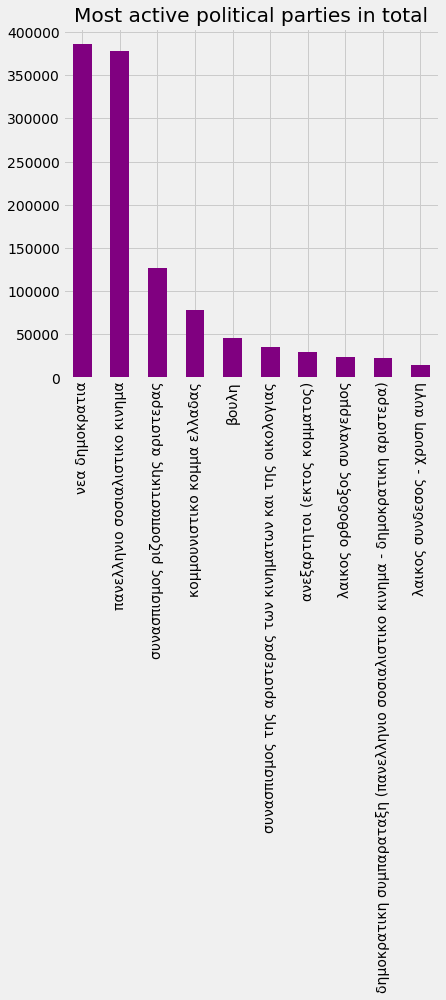

In [ ]:
plt.style.use('fivethirtyeight')
f, g = plt.subplots(figsize=(6, 6))
proceedings['political_party'].value_counts().head(10).plot.bar(color="purple")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Most active political parties in total")
plt.show(g)

It seems like the political party named "νεα δημοκρατια" has the most speech records. So, we will try to generate a speech that looks like it was made by someone who belongs in this specific political party.

In [ ]:
proceedings = proceedings.loc[proceedings['political_party'].isin(['νεα δημοκρατια'])].copy()
proceedings

,political_party,speech
9,νεα δημοκρατια,"Κυρίες και κύριοι συνάδελφοι, αναλαμβάνοντας ..."
11,νεα δημοκρατια,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...
13,νεα δημοκρατια,"Μοιράζονται τώρα, κύριε Τσοβόλα. Παρακαλώ του..."
14,νεα δημοκρατια,Υπάρχει κανείς από τους κυρίους συναδέλφους π...
15,νεα δημοκρατια,"Κύριοι συνάδελφοι, κατά τη διεξαχθείσα μυστικ..."
...,...,...
1194400,νεα δημοκρατια,"Πριν φύγετε, να τα καταθέσετε στα Πρακτικά γι..."
1194401,νεα δημοκρατια,Τα υπόλοιπα στη δευτερολογία σας.Κύριε Συντυχ...
1194403,νεα δημοκρατια,"Ορίστε, κύριε Υπουργέ, έχετε τον λόγο."
1194404,νεα δημοκρατια,"Αρκεί και το κεντρικό κράτος, κύριε Υπουργέ, ..."


The first thing we need to do is alter the way our data are showcased. More specifically, we need to convert them from single rows to a comprehesive text, in order to make it more easy to preprocess our data and use them to train our model. To do so, we first need to remove all the NaN values and all the numbers from the speeches.

In [ ]:
proceedings.isna().sum()

political_party    0
speech             6
dtype: int64

In [ ]:
proceedings.dropna(inplace=True)
proceedings.reset_index(drop=True, inplace=True)
print(proceedings.shape)
proceedings.head()

(385634, 2)


,political_party,speech
0,νεα δημοκρατια,"Κυρίες και κύριοι συνάδελφοι, αναλαμβάνοντας ..."
1,νεα δημοκρατια,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...
2,νεα δημοκρατια,"Μοιράζονται τώρα, κύριε Τσοβόλα. Παρακαλώ του..."
3,νεα δημοκρατια,Υπάρχει κανείς από τους κυρίους συναδέλφους π...
4,νεα δημοκρατια,"Κύριοι συνάδελφοι, κατά τη διεξαχθείσα μυστικ..."


In [ ]:
proceedings['speech'] = proceedings['speech'].str.replace('\d+', '')
proceedings

,political_party,speech
0,νεα δημοκρατια,"Κυρίες και κύριοι συνάδελφοι, αναλαμβάνοντας ..."
1,νεα δημοκρατια,Η Βουλή παρέσχε τη ζητηθείσα εξουσιοδότηση. Μ...
2,νεα δημοκρατια,"Μοιράζονται τώρα, κύριε Τσοβόλα. Παρακαλώ του..."
3,νεα δημοκρατια,Υπάρχει κανείς από τους κυρίους συναδέλφους π...
4,νεα δημοκρατια,"Κύριοι συνάδελφοι, κατά τη διεξαχθείσα μυστικ..."
...,...,...
385629,νεα δημοκρατια,"Πριν φύγετε, να τα καταθέσετε στα Πρακτικά γι..."
385630,νεα δημοκρατια,Τα υπόλοιπα στη δευτερολογία σας.Κύριε Συντυχ...
385631,νεα δημοκρατια,"Ορίστε, κύριε Υπουργέ, έχετε τον λόγο."
385632,νεα δημοκρατια,"Αρκεί και το κεντρικό κράτος, κύριε Υπουργέ, ..."


In [ ]:
speeches = ''.join(proceedings.speech)

Now, let us see the number of unique characters our text consists of:

In [ ]:
vocab = sorted(set(speeches))
print('{} unique characters'.format(len(vocab)))

248 unique characters


## Data Preprocessing / Vectorizing

First of all, we are going to convert the strings to a numerical values.
In order to do so, we will use `preprocessing.StringLookup`:

In [ ]:
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab))

However, we need the result to be readable and understandable, which means that we need to convert again the numeric IDs to characters. This will generate a so called "Ragged Tensor", which is a tensor that is not necessarily rectangular:

In [ ]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True)

We will also use a support function for a successful conversion:

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

## Prediction

Let us examine for a minute how we are going to work in this prediction:
* We will split the speeches file (the text) in separate sequences that all have a specific length. This will be our train data.
* For every input sequence, its target sequence will have the same length shifted by one character to the right.
* This will help us find the next most likely to occur sequence of characters.

<i>Note that a sequence of characters can consist ever from one character.</i>

So, let us create the training examples and targets, in the way that was mentioned above. Starting off, we will split our text into a tensor of integer IDs:

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(speeches, 'UTF-8'))
all_ids

<tf.Tensor: shape=(339098993,), dtype=int64, numpy=array([  3, 140, 182, ..., 139, 148,   3])>

Then, we will convert this tensor into a dataset, in order to proceed:

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

And we will define our sequences' length to 100 characters:

In [ ]:
seq_length = 100
examples_per_epoch = len(speeches)//(seq_length+1)

With the `batch` method we will proceed to the actual convertion of these individual characters to the sequences:

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b' ' b'\xce\x9a' b'\xcf\x85' b'\xcf\x81' b'\xce\xaf' b'\xce\xb5'
 b'\xcf\x82' b' ' b'\xce\xba' b'\xce\xb1' b'\xce\xb9' b' ' b'\xce\xba'
 b'\xcf\x8d' b'\xcf\x81' b'\xce\xb9' b'\xce\xbf' b'\xce\xb9' b' '
 b'\xcf\x83' b'\xcf\x85' b'\xce\xbd' b'\xce\xac' b'\xce\xb4' b'\xce\xb5'
 b'\xce\xbb' b'\xcf\x86' b'\xce\xbf' b'\xce\xb9' b',' b' ' b'\xce\xb1'
 b'\xce\xbd' b'\xce\xb1' b'\xce\xbb' b'\xce\xb1' b'\xce\xbc' b'\xce\xb2'
 b'\xce\xac' b'\xce\xbd' b'\xce\xbf' b'\xce\xbd' b'\xcf\x84' b'\xce\xb1'
 b'\xcf\x82' b' ' b'\xcf\x84' b'\xce\xb7' b'\xce\xbd' b' ' b'\xce\xa0'
 b'\xcf\x81' b'\xce\xbf' b'\xce\xb5' b'\xce\xb4' b'\xcf\x81' b'\xce\xaf'
 b'\xce\xb1' b' ' b'\xcf\x84' b'\xce\xbf' b'\xcf\x85' b' ' b'\xce\xa3'
 b'\xcf\x8e' b'\xce\xbc' b'\xce\xb1' b'\xcf\x84' b'\xce\xbf' b'\xcf\x82'
 b' ' b'\xce\xb8' b'\xce\xb1' b' ' b'\xce\xae' b'\xce\xb8' b'\xce\xb5'
 b'\xce\xbb' b'\xce\xb1' b' ' b'\xce\xba' b'\xce\xb1' b'\xcf\x84' b"'"
 b' ' b'\xce\xb1' b'\xcf\x81' b'\xcf\x87' b'\xce\xae' b'\xce\xbd' 

Obviously, we can not efficiently understand the result above. But joining all the tokens back into strings will help:

In [ ]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy().decode('utf-8'))

 Κυρίες και κύριοι συνάδελφοι, αναλαμβάνοντας την Προεδρία του Σώματος θα ήθελα κατ' αρχήν να ευχαρισ
τήσω όσους με ψήφισαν. Αλλά θα ήθελα να ευχαριστήσω επίσης και όσους δεν με εψήφισαν. Το τεκμήριο της
 δημοκρατικότητος και συνεπώς και της νομιμότητος μιας εκλογής δεν είναι μόνο οι θετικές, αλλά είναι 
και οι αρνητικές ψήφοι. Δεν είναι μόνο τα ΝΑΙ, αλλά και τα ΟΧΙ που πιστοποιούν ότι το σύστημα λειτουρ
γεί. Ο Πρόεδρος της Βουλής δεν είναι βέβαια πρόσωπο υπερκομματικό. Προέρχεται από κάποια παράταξη. Ο 


Moving on, we will create the input text and the target text for each and every sequence. The function below takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

And it works like this:

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

Now, we will create a dataset of these sequences:

In [ ]:
dataset = sequences.map(split_input_target)

A random input and target example:

In [ ]:
for input_example, target_example in  dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy().decode('utf-8'))
  print("Target:", text_from_ids(target_example).numpy().decode('utf-8'))

Input :  Κυρίες και κύριοι συνάδελφοι, αναλαμβάνοντας την Προεδρία του Σώματος θα ήθελα κατ' αρχήν να ευχαρι
Target: Κυρίες και κύριοι συνάδελφοι, αναλαμβάνοντας την Προεδρία του Σώματος θα ήθελα κατ' αρχήν να ευχαρισ


Next, we are going to create the training batches. In order to do so, we will split the text into manageable sequences. However, before we proceed, we need to shuffle the data and pack it into batches:

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## Build the Model

Finally, we are ready to build our prediction model. In this model we will use the layers mentioned below:
* An Embedding layer which will be the input layer and it will map each character-ID to a vector with embedding_dim dimensions;
* A GRU layer, which is an RNN 
* A Dense layer, which will be the output layer and have as many neurons as the vocabulary size, since we want the output to show us the probability of a specific characters to occur next.

In [ ]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

Instead of building a model straight away, we will build it inside a Keras class, as a subclass:

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True, 
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else: 
      return x

In [ ]:
model = MyModel(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Try the Model

Let us run the model and see how it behaves:

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 250) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  64000     
_________________________________________________________________
gru (GRU)                    multiple                  3938304   
_________________________________________________________________
dense (Dense)                multiple                  256250    
Total params: 4,258,554
Trainable params: 4,258,554
Non-trainable params: 0
_________________________________________________________________


## Train the Model

First, we will define our loss function and we are going to use the Sparse Categorical Cross Entropy, since we are finally addressing a simple classification problem with more than 2 classes:

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

And we will also define our optimizer:

In [ ]:
model.compile(optimizer='adam', loss=loss)

Next, we are going to configure the checkpoints. It is not mandatory that we do it, but it is good practice since it is possibly going to take some time for the model to run:

In [ ]:
checkpoint_dir = './training_checkpoints-speeches-nd'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    verbose=1,
    save_weights_only=True)

## Execute the Training

Finally, we are going to train our model. Due to time constraints, I am going to train it for only `30 epochs`. Of course, this will not give un an outstanting result. However, I suggest that you try it for at least 50 epochs. <br> <i>If you are working on Google Colab, make sure that you hace set the runtime to GPU for faster training.</i>

In [ ]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
52459/52459 [==============================] - 2240s 43ms/step - loss: 1.4460

Epoch 00001: saving model to ./training_checkpoints-speeches-nd/ckpt_1
Epoch 2/30
52459/52459 [==============================] - 2225s 42ms/step - loss: 2.0610

Epoch 00002: saving model to ./training_checkpoints-speeches-nd/ckpt_2
Epoch 3/30
52459/52459 [==============================] - 2229s 42ms/step - loss: 2.0633

Epoch 00003: saving model to ./training_checkpoints-speeches-nd/ckpt_3
Epoch 4/30
31682/52459 [=================>............] - ETA: 14:41 - loss: 2.0606

<i> Due to limited time and after making some changes, I was not able to run the last time all the training for 30 epochs, so the training had to be interrupted in order to turn in the assignment. If you please, you can of course run all the training process. <i>

## Generate Speech

The simplest way to generate text with this model is to run it in a loop, and keep track of the model's internal state as you execute it.

Each time you call the model you pass in some text and an internal state. The model returns a prediction for the next character and its new state. Pass the prediction and state back in to continue generating text.



In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature=temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    skip_ids = self.ids_from_chars(['','[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        values=[-float('inf')]*len(skip_ids),
        indices = skip_ids,
        dense_shape=[len(ids_from_chars.get_vocabulary())]) 
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    predicted_logits, states =  self.model(inputs=input_ids, states=states, 
                                          return_state=True)
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    predicted_logits = predicted_logits + self.prediction_mask

    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    predicted_chars = self.chars_from_ids(predicted_ids)

    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

Netx, we will run it in a loop to generate a text:

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['νεα δημοκρατια: '])
result = [next_char]

for n in range(150):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()

print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)

print(f"\nRun time: {end - start}")

Probably, running the model for more epochs could give us a better fitted generated text. However, we should be carefull so that we avoid overfitting.

---